In [1]:
import pandas as pd
import numpy as np
import os.path as op
import seaborn as sns
from nilearn import surface
import pingouin
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Helvetica'

bids_folder = '/data/ds-numrisk/'

/Users/gdehol/mambaforge/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
df = []


for type in ['trialwise']:
    for subject in range(1, 65):
        for mask in ['NPC_L', 'NPC_R']:
            for run in range(1, 7):
                try:
                    d = pd.read_csv(op.join(bids_folder, 'derivatives', f'decoding3_{type}_smoothed',
                                             f'sub-{subject}', 'func', f'sub-{subject}_run-{run}_mask-{mask}_pdf.tsv'), sep='\t', 
                                             header=[0], index_col=[0,1])

                    d.columns = d.columns.astype(np.float32)
                    d['type'], d['subject'], d['mask'], d['run'] = type, subject, mask, run
                    df.append(d.set_index(['type', 'subject', 'mask', 'run'], append=True))

                except Exception as e:
                    print(f"Problem with subject {subject}:{e}")

    
df = pd.concat(df)

df.shape

(27648, 279)

In [3]:
df.columns = np.exp(df.columns.astype(np.float32))
df.columns = np.round((df.columns * 2)) / 2.

In [4]:
pars = (df.columns[np.newaxis,:] * df).sum(1).to_frame('E')
pars['map'] = df.idxmax(1)
pars['sd'] = (np.abs(pars['E'].values[:, np.newaxis] - df.columns.astype(np.float32)[np.newaxis, :]) * df).sum(1).to_frame('sd')

pars = pars.reset_index(['stimulus', 'log(stimulus)'])
pars['log_error'] =  np.log(pars['E']) - pars['log(stimulus)']
pars['abs(log_error)'] = pars['log_error'].abs()

pars['error'] =  pars['E'] - pars['stimulus']
pars['abs(error)'] = pars['error'].abs()

stimuli = [5, 7, 10, 14, 20, 28]

pars['E2'] = (np.array(stimuli)[np.newaxis, :] * df[stimuli] / df[stimuli].sum(1).values[:, np.newaxis]).sum(1).values


pars['sd2'] = ((np.abs(pars['E2'].values[:, np.newaxis] - np.array(stimuli)[np.newaxis, :])  * df[stimuli]).sum(1) / df[stimuli].sum(1)).values

pars['map2'] = df[stimuli].idxmax(1).values


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_98145/1412161451.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  pars = (df.columns[np.newaxis,:] * df).sum(1).to_frame('E')
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_98145/1412161451.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  pars['sd'] = (np.abs(pars['E'].values[:, np.newaxis] - df.columns.astype(np.float32)[np.newaxis, :]) * df).sum(1).to_frame('sd')


In [5]:
pars['argmax_num'] = df[[5, 7, 10, 14, 20, 28]].idxmax(1).values

In [6]:
pars['correct_argmax'] = pars['argmax_num'] == pars['stimulus']

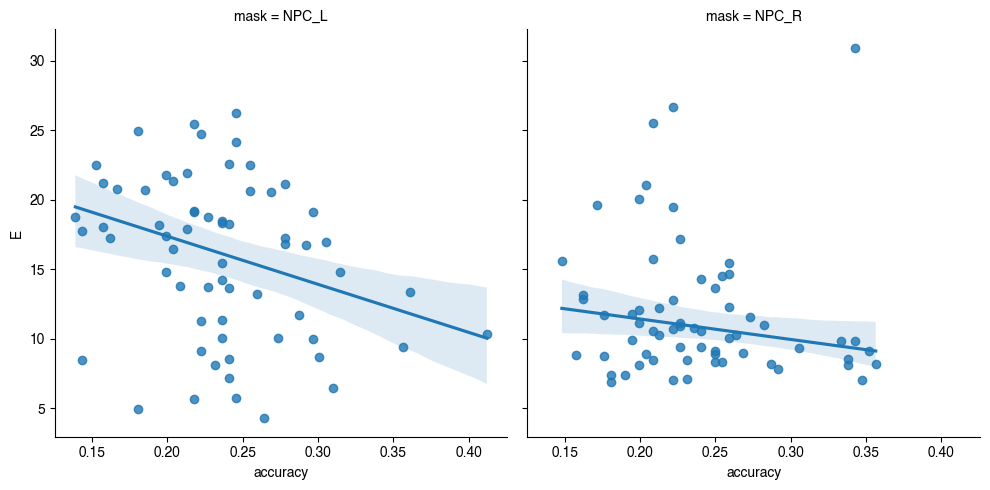

In [7]:
subjectwise_accuracy = pars.groupby(['subject', 'mask'])['correct_argmax'].mean().to_frame('accuracy')
tmp = pars.groupby(['mask', 'subject']).std().join(subjectwise_accuracy)
fac = sns.lmplot(tmp.reset_index(), x='accuracy', y='E', col='mask', robust=True)
# fac.map(lambda *args, **kwargs: plt.axvline(1/6., c='k', ls='--'))

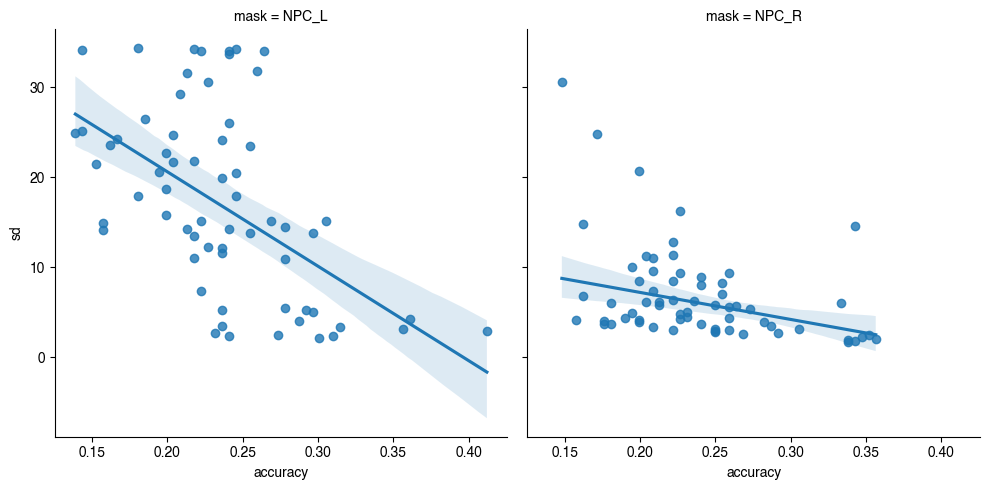

In [8]:
subjectwise_accuracy = pars.groupby(['subject', 'mask'])['correct_argmax'].mean().to_frame('accuracy')
tmp = pars.groupby(['mask', 'subject']).mean().join(subjectwise_accuracy)
fac = sns.lmplot(tmp.reset_index(), x='accuracy', y='sd', col='mask', robust=True)
# fac.map(lambda *args, **kwargs: plt.axvline(1/6., c='k', ls='--'))

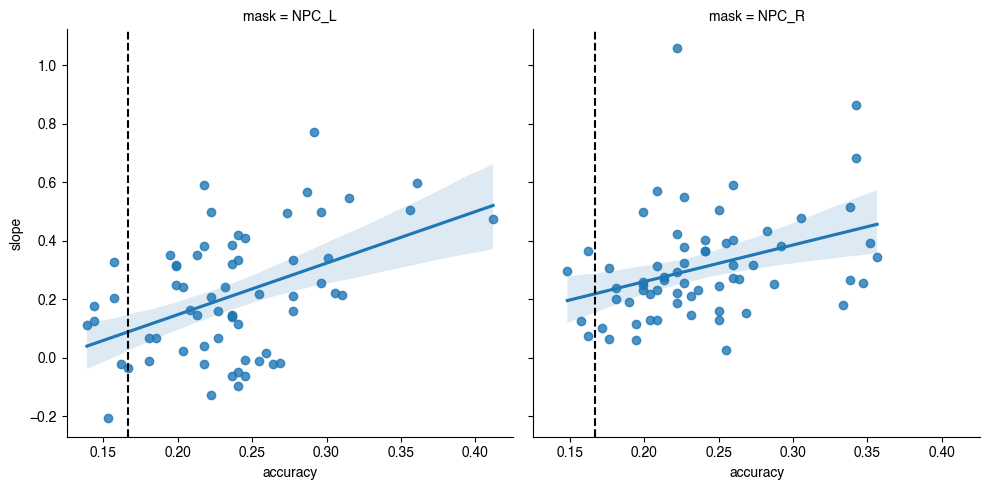

In [9]:
# r = pars.groupby(['mask', 'subject']).apply(lambda d: pingouin.corr(d['stimulus'], d['E']))[['r']].droplevel(-1)

slopes = pars.groupby(['mask', 'subject']).apply(lambda d: sm.OLS(d['E'], sm.add_constant(d['stimulus'])).fit().params['stimulus']).to_frame('slope')

tmp = subjectwise_accuracy.join(slopes)

fac = sns.lmplot(tmp.reset_index(), x='accuracy', y='slope', col='mask')
fac.map(lambda *args, **kwargs: plt.axvline(1/6., c='k', ls='--'))

In [10]:
subjectwise_accuracy

accuracy
subject mask           
1       NPC_L  0.287037
        NPC_R  0.240741
2       NPC_L  0.199074
        NPC_R  0.199074
3       NPC_L  0.166667
...                 ...
62      NPC_R  0.208333
63      NPC_L  0.203704
        NPC_R  0.175926
64      NPC_L  0.217593
        NPC_R  0.226852

[128 rows x 1 columns]

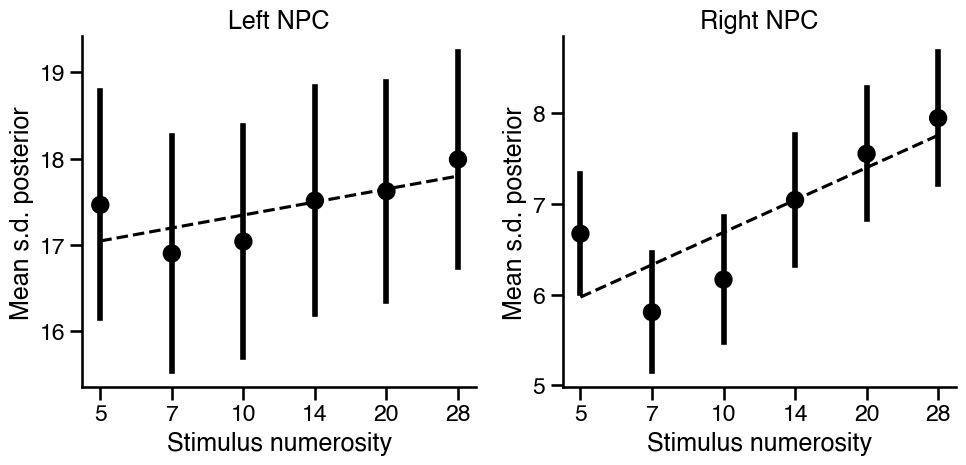

In [11]:
from sklearn import linear_model
import matplotlib.pyplot as plt
sns.set_context('talk')


tmp = pars.query('mask in ["NPC_L", "NPC_R"]').loc['trialwise'].groupby(['subject', 'mask', 'stimulus']).mean().reset_index()

fac = sns.catplot(x='stimulus', y='sd', col='mask',
           data=tmp, 
#                   col_wrap=1,
           kind='point', sharey=False,
                  palette=['k'],
                  errorbar='se')
#                  line_kws={'lw':1., 'c':'k'})

fac.set(ylabel='Mean s.d. posterior')
fac.set(xlabel='Stimulus numerosity')

tmp = pars.query('mask in ["NPC_L", "NPC_R"]').loc['trialwise'].groupby(['subject', 'mask', 'stimulus']).mean().reset_index()

model = linear_model.LinearRegression()
tmp = tmp.groupby(['mask', 'stimulus']).mean()['sd']
model.fit(np.arange(6)[:, np.newaxis], tmp.loc['NPC_L'].values[:, np.newaxis])
fac.axes[0][0].plot(model.predict(np.arange(6)[:, np.newaxis]), c='k', ls='--')
fac.axes[0][0].set_title('Left NPC')

model.fit(np.arange(6)[:, np.newaxis], tmp.loc['NPC_R'].values[:, np.newaxis])
fac.axes[0][1].plot(model.predict(np.arange(6)[:, np.newaxis]), c='k', ls='--')
fac.axes[0][1].set_title('Right NPC')
plt.tight_layout()

plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/response_nhb/ds_2022.pdf', transparent=False)

In [12]:
pars

stimulus  log(stimulus)          E   map  \
type      subject mask  run                                             
trialwise 1       NPC_L 1           5       1.609438  12.286325  13.5   
                        1           5       1.609438   5.808768   5.5   
                        1           5       1.609438  10.185809   7.5   
                        1           5       1.609438   8.345406   7.5   
                        1           5       1.609438   7.010080   6.5   
...                               ...            ...        ...   ...   
          64      NPC_R 6          28       3.332205  12.243699   7.5   
                        6          28       3.332205  28.587882  20.0   
                        6          28       3.332205  10.957720   7.0   
                        6          28       3.332205   8.213272   7.0   
                        6          28       3.332205  14.332187   7.0   

                                    sd  log_error  abs(log_error)      error  \
type      subject mask  run                                                    
trialwise 1       NPC_L 1     2.571717   0.899049        0.899049   7.286325   
                        1     0.694117   0.149931        0.149931   0.808768   
                        1     4.923734   0.711558        0.711558   5.185809   
                        1     1.328078   0.512273        0.512273   3.345406   
                        1     1.080027   0.337911        0.337911   2.010080   
...                                ...        ...             ...        ...   
          64      NPC_R 6     5.774293  -0.827193        0.827193 -15.756301   
                        6    17.215751   0.020778        0.020778   0.587882   
                        6     5.857443  -0.938160        0.938160 -17.042280   
                        6     3.465901  -1.226453        1.226453 -19.786728   
                        6     8.066206  -0.669697        0.669697 -13.667813   

                             abs(error)         E2       sd2  map2  \
type      subject mask  run                                          
trialwise 1       NPC_L 1      7.286325  12.196668  2.510032  14.0   
                        1      0.808768   5.568022  0.816310   5.0   
                        1      5.185809   7.665227  2.065623   7.0   
                        1      3.345406   7.497406  0.891483   7.0   
                        1      2.010080   6.885903  0.261863   7.0   
...                                 ...        ...       ...   ...   
          64      NPC_R 6     15.756301  10.154190  3.361736   7.0   
                        6      0.587882  16.190751  5.891667  20.0   
                        6     17.042280   7.477796  0.961264   7.0   
                        6     19.786728   6.390160  0.995469   7.0   
                        6     13.667813   9.431822  3.636260   7.0   

                             argmax_num  correct_argmax  
type      subject mask  run                              
trialwise 1       NPC_L 1          14.0           False  
                        1           5.0            True  
                        1           7.0           False  
                        1           7.0           False  
                        1           7.0           False  
...                                 ...             ...  
          64      NPC_R 6           7.0           False  
                        6          20.0           False  
                        6           7.0           False  
                        6           7.0           False  
                        6           7.0           False  

[27648 rows x 14 columns]

In [13]:
# plt.subplot(121)
confusion_matrix = pars.loc['trialwise'].xs('NPC_L', 0, 'mask').groupby(['stimulus', 'map2']).count().unstack('map2')['map']

confusion_matrix = confusion_matrix / confusion_matrix.sum(0)

# np.diag(confusion_matrix)

accuracies = []

for stimulus, row in confusion_matrix.iterrows():
    acc = row.loc[stimulus] / (row.drop(stimulus) + row.loc[stimulus])
    accuracies.append(acc)
accuracies = pd.concat(accuracies)
print(f'Pairwise accuracy NPC_L (six categories): {accuracies.mean()*100:2.1f}%')

accuracies = []

for stimulus, row in confusion_matrix.loc[[5, 7, 10],[5, 7, 10]].iterrows():
    acc = row.loc[stimulus] / (row.drop(stimulus) + row.loc[stimulus])
    accuracies.append(acc)
accuracies = pd.concat(accuracies)
print(f'Pairwise accuracy NPC_L (three categories, 5/7/10): {accuracies.mean()*100:2.1f}%')

accuracies = []
for stimulus, row in confusion_matrix.loc[[14, 20, 28],[14, 20, 28]].iterrows():
    acc = row.loc[stimulus] / (row.drop(stimulus) + row.loc[stimulus])
    accuracies.append(acc)
accuracies = pd.concat(accuracies)
print(f'Pairwise accuracy NPC_L (three categories, 14/20/28): {accuracies.mean()*100:2.1f}%')

confusion_matrix = pars.loc['trialwise'].xs('NPC_R', 0, 'mask').groupby(['stimulus', 'map2']).count().unstack('map2')['map']

confusion_matrix = confusion_matrix / confusion_matrix.sum(0)
# np.diag(confusion_matrix)
accuracies = []

for stimulus, row in confusion_matrix.iterrows():
    acc = row.loc[stimulus] / (row.drop(stimulus) + row.loc[stimulus])
    accuracies.append(acc)
accuracies = pd.concat(accuracies)
print(f'Pairwise accuracy NPC_R (six categories): {accuracies.mean()*100:2.1f}%')


confusion_matrix = confusion_matrix.set_index(pd.Index([1, 1, 2,2, 3, 3], name='raw category'), append=True).T
confusion_matrix = confusion_matrix.set_index(pd.Index([1, 1, 2,2, 3, 3], name='raw category'), append=True).T

accuracies = []

for stimulus, row in confusion_matrix.loc[[5, 7, 10],[5, 7, 10]].iterrows():
    acc = row.loc[stimulus] / (row.drop(stimulus) + row.loc[stimulus])
    accuracies.append(acc)
accuracies = pd.concat(accuracies)
print(f'Pairwise accuracy NPC_R (three categories, 5/10/20): {accuracies.mean()*100:2.1f}%')

accuracies = []
for stimulus, row in confusion_matrix.loc[[14, 20, 28],[14, 20, 28]].iterrows():
    acc = row.loc[stimulus] / (row.drop(stimulus) + row.loc[stimulus])
    accuracies.append(acc)
accuracies = pd.concat(accuracies)
print(f'Pairwise accuracy NPC_R (three categories, 7/14/28): {accuracies.mean()*100:2.1f}%')

Pairwise accuracy NPC_L (six categories): 61.0%
Pairwise accuracy NPC_L (three categories, 5/7/10): 58.5%
Pairwise accuracy NPC_L (three categories, 14/20/28): 54.8%
Pairwise accuracy NPC_R (six categories): 61.1%
Pairwise accuracy NPC_R (three categories, 5/10/20): 58.9%
Pairwise accuracy NPC_R (three categories, 7/14/28): 54.2%


In [14]:
from itertools import product

In [15]:
unique_ns = df.index.unique(level='stimulus').tolist()

acc = []
keys = []
for ix1, ix2 in product(*([unique_ns]*2)):
    # print(ix1, ix2)
    keys.append((ix1, ix2))

    acc.append(df[ix1] > df[ix2])

acc= pd.concat(acc, keys=keys, names=['ix1', 'ix2']).to_frame('accuracy')


In [16]:
acc = acc.reset_index()
acc = acc[(acc.ix1 == acc.stimulus) & (acc.ix2 != acc.stimulus)]

In [17]:
acc.groupby(['stimulus', 'ix2']).mean().unstack('ix2')['accuracy']

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_98145/349762700.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  acc.groupby(['stimulus', 'ix2']).mean().unstack('ix2')['accuracy']


ix2,5,7,10,14,20,28
stimulus,,,,,,
5,NaN,0.545356,0.598741,0.608507,0.627387,0.631510
7,0.585286,NaN,0.544922,0.573351,0.632378,0.654080
10,0.616319,0.567708,NaN,0.541016,0.602865,0.639323
14,0.630859,0.602648,0.546441,NaN,0.557075,0.604167
20,0.623264,0.636936,0.591146,0.518446,NaN,0.570747
28,0.611328,0.643012,0.607422,0.527778,0.485243,NaN


In [18]:
acc.groupby('mask')['accuracy'].mean()

mask
NPC_L    0.591276
NPC_R    0.590408
Name: accuracy, dtype: float64

In [19]:
# Brain-behavior correlations

In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import os.path as op
import seaborn as sns
from nilearn import surface
import pingouin
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvetica'


bids_folder = '/data/ds-numrisk/'

In [21]:
neural_results = pd.read_csv(op.join(bids_folder, 'derivatives', 'summary_data', 'neural_results_aug2021.tsv'), sep='\t')
neural_results = neural_results.set_index(['type', 'subject', 'mask'])
neural_results['log(neural precision)'] = np.log(neural_results['neural precision'])

neural_results = neural_results.xs('NPC_R', 0, 'mask').xs('trialwise', 0, 'type')


behav = pd.read_csv(op.join(bids_folder, 'derivatives','summary_data', 'riskPrecision_data.csv')).set_index('subject')
behav.index = behav.index.astype(int)

from pandas import IndexSlice as ix_

In [22]:
df = behav.join(neural_results)

In [23]:
df['Perceptual precision'] = df['mag_prec']

df['Risk precision (non-symbolic)'] = df['riskprec_coin']
df['Risk precision (symbolic)'] = df['riskprec_sym']

df['log(Risk precision (non-symbolic))'] = np.log(df['riskprec_coin'])
df['log(Risk precision (symbolic))'] = np.log(df['riskprec_sym'])

df['RNP (non-symbolic)'] = df['rnp_coin']
df['RNP (symbolic)'] = df['rnp_sym']



neural_regressors = ['log(neural precision)', 'slope']

behavioral_regressors = ['Perceptual precision', 'Risk precision (non-symbolic)', 
                        'Risk precision (symbolic)', 'RNP (non-symbolic)',
                        'RNP (symbolic)',
                        'log(Risk precision (non-symbolic))',
                        'log(Risk precision (symbolic))']

In [24]:
from itertools import product

In [27]:
pingouin.corr(df[br], df[nr], method='pearson')

,n,r,CI95%,p-val,BF10,power
pearson,64,-0.29526,"[-0.5, -0.05]",0.017856,2.423,0.667509


In [32]:
rs = []
keys = []

for br, nr in product(behavioral_regressors, neural_regressors):
    rs.append(pingouin.corr(df[br], df[nr], method='pearson').iloc[0])
    keys.append((br, nr))
    
rs = pd.concat(rs, keys=keys, names=['behavior', 'neural'])
rs = rs.unstack()[['r', 'p-val', 'CI95%']].rename(columns={'p-val': 'p-val (two-sided)'})
rs.columns.name = 'parameter'
# rs['p-val (one-sided)'] = rs['p-val (two-sided)'] / 2.
# rs = rs.drop('p-val (two-sided)', 1)
# rs = rs.stack().unstack(['neural', 'parameter'])

# rs.astype(float).round(3)

In [33]:
rs

r  \
behavior                           neural                            
Perceptual precision               log(neural precision)  0.404148   
                                   slope                 -0.059464   
RNP (non-symbolic)                 log(neural precision)  0.258423   
                                   slope                 -0.267877   
RNP (symbolic)                     log(neural precision)  0.085259   
                                   slope                  -0.14004   
Risk precision (non-symbolic)      log(neural precision)  0.121598   
                                   slope                 -0.213259   
Risk precision (symbolic)          log(neural precision)  0.117794   
                                   slope                  -0.18007   
log(Risk precision (non-symbolic)) log(neural precision)  0.189544   
                                   slope                 -0.354155   
log(Risk precision (symbolic))     log(neural precision)  0.150686   
                                   slope                  -0.29526   

                                                         p-val (two-sided)  \
behavior                           neural                                    
Perceptual precision               log(neural precision)          0.000926   
                                   slope                           0.64068   
RNP (non-symbolic)                 log(neural precision)          0.039227   
                                   slope                           0.03235   
RNP (symbolic)                     log(neural precision)          0.502955   
                                   slope                          0.269727   
Risk precision (non-symbolic)      log(neural precision)          0.338483   
                                   slope                          0.090651   
Risk precision (symbolic)          log(neural precision)           0.35392   
                                   slope                          0.154493   
log(Risk precision (non-symbolic)) log(neural precision)          0.133588   
                                   slope                          0.004091   
log(Risk precision (symbolic))     log(neural precision)          0.234623   
                                   slope                          0.017856   

                                                                   CI95%  
behavior                           neural                                 
Perceptual precision               log(neural precision)    [0.18, 0.59]  
                                   slope                    [-0.3, 0.19]  
RNP (non-symbolic)                 log(neural precision)    [0.01, 0.47]  
                                   slope                  [-0.48, -0.02]  
RNP (symbolic)                     log(neural precision)   [-0.16, 0.32]  
                                   slope                   [-0.37, 0.11]  
Risk precision (non-symbolic)      log(neural precision)   [-0.13, 0.36]  
                                   slope                   [-0.44, 0.03]  
Risk precision (symbolic)          log(neural precision)   [-0.13, 0.35]  
                                   slope                   [-0.41, 0.07]  
log(Risk precision (non-symbolic)) log(neural precision)   [-0.06, 0.42]  
                                   slope                  [-0.55, -0.12]  
log(Risk precision (symbolic))     log(neural precision)    [-0.1, 0.38]  
                                   slope                   [-0.5, -0.05]

In [82]:
rs = []
keys = []

for br, nr in product(behavioral_regressors, neural_regressors):
    rs.append(pingouin.corr(df[br], df[nr], method='spearman').iloc[0])
    keys.append((br, nr))
    
rs = pd.concat(rs, keys=keys, names=['behavior', 'neural'])
rs = rs.unstack()[['r', 'p-val', ]].rename(columns={'p-val': 'p-val (two-sided)'})
rs.columns.name = 'parameter'
rs['p-val (one-sided)'] = rs['p-val (two-sided)'] / 2.
rs = rs.drop('p-val (two-sided)', 1)
rs = rs.stack().unstack(['neural', 'parameter'])

rs.astype(float).round(3)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83964/4158020701.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  rs = rs.drop('p-val (two-sided)', 1)


neural                             log(neural precision)                    \
parameter                                              r p-val (one-sided)   
behavior                                                                     
Perceptual precision                               0.374             0.001   
RNP (non-symbolic)                                 0.230             0.034   
RNP (symbolic)                                     0.092             0.234   
Risk precision (non-symbolic)                      0.137             0.140   
Risk precision (symbolic)                          0.111             0.192   
log(Risk precision (non-symbolic))                 0.137             0.140   
log(Risk precision (symbolic))                     0.111             0.192   

neural                              slope                    
parameter                               r p-val (one-sided)  
behavior                                                     
Perceptual precision               -0.114             0.186  
RNP (non-symbolic)                 -0.059             0.322  
RNP (symbolic)                     -0.117             0.178  
Risk precision (non-symbolic)      -0.162             0.101  
Risk precision (symbolic)          -0.112             0.189  
log(Risk precision (non-symbolic)) -0.162             0.101  
log(Risk precision (symbolic))     -0.112             0.189

In [83]:
import statsmodels.api as sm
from scipy.stats import zscore

In [84]:
rs = []
keys = []

for br, nr in product(behavioral_regressors, neural_regressors):
    # rs.append(pingouin.corr(df[br], df[nr], method='spearman').iloc[0])
    keys.append((br, nr))

    df[br] = zscore(df[br])
    df[nr] = zscore(df[nr])

    r = sm.RLM(df[br], sm.add_constant(df[nr]), sm.robust.norms.TrimmedMean()).fit() 

    tmp = pd.concat((r.params, r.pvalues), axis=1, keys=['params', 'p_values'])
    rs.append(tmp)
    
rs = pd.concat(rs, keys=keys, names=['behavior', 'neural']).drop('const', level=-1)
rs['p-value (one-side)'] = rs['p_values']#.round(5) / 2.

# rs.round(3)
rs

params  \
behavior                           neural                                                  
Perceptual precision               log(neural precision) log(neural precision)  0.457308   
                                   slope                 slope                 -0.182728   
Risk precision (non-symbolic)      log(neural precision) log(neural precision)  0.250317   
                                   slope                 slope                 -0.448022   
Risk precision (symbolic)          log(neural precision) log(neural precision)  0.117794   
                                   slope                 slope                 -0.180070   
RNP (non-symbolic)                 log(neural precision) log(neural precision)  0.168356   
                                   slope                 slope                 -0.306706   
RNP (symbolic)                     log(neural precision) log(neural precision)  0.059963   
                                   slope                 slope                 -0.189842   
log(Risk precision (non-symbolic)) log(neural precision) log(neural precision)  0.080787   
                                   slope                 slope                 -0.180375   
log(Risk precision (symbolic))     log(neural precision) log(neural precision)  0.091033   
                                   slope                 slope                 -0.063704   

                                                                                    p_values  \
behavior                           neural                                                      
Perceptual precision               log(neural precision) log(neural precision)  3.002236e-06   
                                   slope                 slope                  1.172364e-01   
Risk precision (non-symbolic)      log(neural precision) log(neural precision)  9.537485e-03   
                                   slope                 slope                  2.135884e-10   
Risk precision (symbolic)          log(neural precision) log(neural precision)  3.502961e-01   
                                   slope                 slope                  1.494612e-01   
RNP (non-symbolic)                 log(neural precision) log(neural precision)  1.033777e-01   
                                   slope                 slope                  3.398653e-03   
RNP (symbolic)                     log(neural precision) log(neural precision)  6.102844e-01   
                                   slope                 slope                  8.343152e-02   
log(Risk precision (non-symbolic)) log(neural precision) log(neural precision)  5.282170e-02   
                                   slope                 slope                  2.031270e-06   
log(Risk precision (symbolic))     log(neural precision) log(neural precision)  3.562417e-01   
                                   slope                 slope                  5.202396e-01   

                                                                                p-value (one-side)  
behavior                           neural                                                           
Perceptual precision               log(neural precision) log(neural precision)        3.002236e-06  
                                   slope                 slope                        1.172364e-01  
Risk precision (non-symbolic)      log(neural precision) log(neural precision)        9.537485e-03  
                                   slope                 slope                        2.135884e-10  
Risk precision (symbolic)          log(neural precision) log(neural precision)        3.502961e-01  
                                   slope                 slope                        1.494612e-01  
RNP (non-symbolic)                 log(neural precision) log(neural precision)        1.033777e-01  
                                   slope                 slope                        3.398653e-03  
RNP (symbolic)                     log(neural precision) log(n

# Remove outliers

In [85]:
tmp = df.sort_values('slope').iloc[:-3]

In [86]:
rs = []
keys = []

for br, nr in product(behavioral_regressors, neural_regressors):
    rs.append(pingouin.corr(tmp[br], tmp[nr], method='pearson').iloc[0])
    keys.append((br, nr))
    
rs = pd.concat(rs, keys=keys, names=['behavior', 'neural'])
rs = rs.unstack()[['r', 'p-val', ]].rename(columns={'p-val': 'p-val (two-sided)'})
rs.columns.name = 'parameter'
rs['p-val (one-sided)'] = rs['p-val (two-sided)'] / 2.
rs = rs.drop('p-val (two-sided)', 1)
rs = rs.stack().unstack(['neural', 'parameter'])

rs.astype(float).round(3)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83964/3537349259.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  rs = rs.drop('p-val (two-sided)', 1)


neural                             log(neural precision)                    \
parameter                                              r p-val (one-sided)   
behavior                                                                     
Perceptual precision                               0.459             0.000   
RNP (non-symbolic)                                 0.184             0.078   
RNP (symbolic)                                     0.073             0.287   
Risk precision (non-symbolic)                      0.059             0.327   
Risk precision (symbolic)                          0.078             0.276   
log(Risk precision (non-symbolic))                 0.074             0.285   
log(Risk precision (symbolic))                     0.064             0.311   

neural                              slope                    
parameter                               r p-val (one-sided)  
behavior                                                     
Perceptual precision               -0.207             0.055  
RNP (non-symbolic)                 -0.037             0.388  
RNP (symbolic)                     -0.137             0.146  
Risk precision (non-symbolic)      -0.074             0.286  
Risk precision (symbolic)          -0.115             0.189  
log(Risk precision (non-symbolic)) -0.058             0.330  
log(Risk precision (symbolic))     -0.122             0.175

In [87]:
df

,mag_prec,mag_noise3,riskprec_sym,riskprec_coin,riskprec_pool,risknoise_sym,risknoise_coin,risknoise_pool,rnp_sym,rnp_coin,...,slope2,intercept2,log(neural precision),Perceptual precision,Risk precision (non-symbolic),Risk precision (symbolic),log(Risk precision (non-symbolic)),log(Risk precision (symbolic)),RNP (non-symbolic),RNP (symbolic)
subject,,,,,,,,,,,,,,,,,,,,,
1,3.46227,0.20423,5.99275,3.45,3.97,0.11799,0.205,0.178,0.56935,0.46163,...,0.048858,1.591253,0.648192,0.742603,0.788192,1.549755,0.588732,1.115379,0.484217,0.968282
2,3.42510,0.20645,5.37317,4.28,4.85,0.13160,0.165,0.146,0.54841,0.57844,...,0.035143,1.943738,0.544686,0.675480,1.639320,1.128993,0.926673,0.908552,1.293648,0.816827
3,2.69401,0.26247,1.51230,1.24,1.26,0.46757,0.569,0.559,0.19108,0.17131,...,-0.006700,3.694826,-2.352760,-0.644744,-1.478064,-1.492959,-1.015335,-1.494152,-1.527546,-1.767676
4,2.37278,0.29801,4.23676,3.01,3.33,0.16690,0.235,0.212,0.58157,0.46852,...,-0.010169,2.582261,-1.119428,-1.224831,0.336992,0.357246,0.374858,0.458217,0.531961,1.056667
5,2.63306,0.26855,2.21593,2.09,2.07,0.31910,0.339,0.342,0.66227,0.58513,...,0.045572,2.206968,0.400435,-0.754810,-0.606427,-1.015117,-0.196965,-0.770110,1.340007,1.640356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,3.87092,0.18267,5.39212,3.40,3.45,0.13114,0.208,0.205,0.54220,0.37187,...,0.002220,1.666994,1.279462,1.480555,0.736919,1.141862,0.565847,0.915224,-0.137772,0.771911
61,2.86120,0.24714,3.37856,2.08,2.61,0.20929,0.340,0.271,0.34048,0.29223,...,0.022941,2.187357,-0.589755,-0.342828,-0.616682,-0.225565,-0.204484,0.029241,-0.689635,-0.687093
62,2.86292,0.24699,4.22899,4.66,4.42,0.16720,0.152,0.160,0.58755,0.64172,...,0.027071,2.290146,-1.079547,-0.339722,2.028993,0.351970,1.060017,0.454738,1.732145,1.099920


In [88]:
tmp = df[df['rnp_coin'] <0.55]

rs = []
keys = []

for br, nr in product(behavioral_regressors, neural_regressors):
    rs.append(pingouin.corr(tmp[br], tmp[nr], method='pearson').iloc[0])
    keys.append((br, nr))
    
rs = pd.concat(rs, keys=keys, names=['behavior', 'neural'])
rs = rs.unstack()[['r', 'p-val', ]].rename(columns={'p-val': 'p-val (two-sided)'})
rs.columns.name = 'parameter'
rs['p-val (one-sided)'] = rs['p-val (two-sided)'] / 2.
rs = rs.drop('p-val (two-sided)', 1)
rs = rs.stack().unstack(['neural', 'parameter'])

rs.astype(float).round(3)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83964/114492852.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  rs = rs.drop('p-val (two-sided)', 1)


neural                             log(neural precision)                    \
parameter                                              r p-val (one-sided)   
behavior                                                                     
Perceptual precision                               0.398             0.001   
RNP (non-symbolic)                                 0.251             0.030   
RNP (symbolic)                                     0.086             0.261   
Risk precision (non-symbolic)                      0.164             0.111   
Risk precision (symbolic)                          0.151             0.131   
log(Risk precision (non-symbolic))                 0.211             0.058   
log(Risk precision (symbolic))                     0.175             0.097   

neural                              slope                    
parameter                               r p-val (one-sided)  
behavior                                                     
Perceptual precision               -0.056             0.341  
RNP (non-symbolic)                 -0.308             0.010  
RNP (symbolic)                     -0.156             0.124  
Risk precision (non-symbolic)      -0.251             0.030  
Risk precision (symbolic)          -0.201             0.067  
log(Risk precision (non-symbolic)) -0.373             0.002  
log(Risk precision (symbolic))     -0.314             0.009

In [89]:
tmp = df[df['rnp_sym'] <0.55]

rs = []
keys = []

for br, nr in product(behavioral_regressors, neural_regressors):
    rs.append(pingouin.corr(tmp[br], tmp[nr], method='pearson').iloc[0])
    keys.append((br, nr))
    
rs = pd.concat(rs, keys=keys, names=['behavior', 'neural'])
rs = rs.unstack()[['r', 'p-val', ]].rename(columns={'p-val': 'p-val (two-sided)'})
rs.columns.name = 'parameter'
rs['p-val (one-sided)'] = rs['p-val (two-sided)'] / 2.
rs = rs.drop('p-val (two-sided)', 1)
rs = rs.stack().unstack(['neural', 'parameter'])

rs.astype(float).round(3)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83964/4149413473.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  rs = rs.drop('p-val (two-sided)', 1)


neural                             log(neural precision)                    \
parameter                                              r p-val (one-sided)   
behavior                                                                     
Perceptual precision                               0.397             0.002   
RNP (non-symbolic)                                 0.306             0.015   
RNP (symbolic)                                     0.132             0.178   
Risk precision (non-symbolic)                      0.173             0.113   
Risk precision (symbolic)                          0.148             0.151   
log(Risk precision (non-symbolic))                 0.220             0.061   
log(Risk precision (symbolic))                     0.181             0.102   

neural                              slope                    
parameter                               r p-val (one-sided)  
behavior                                                     
Perceptual precision               -0.083             0.281  
RNP (non-symbolic)                 -0.327             0.010  
RNP (symbolic)                     -0.127             0.188  
Risk precision (non-symbolic)      -0.273             0.026  
Risk precision (symbolic)          -0.207             0.073  
log(Risk precision (non-symbolic)) -0.395             0.002  
log(Risk precision (symbolic))     -0.327             0.010

In [90]:
# NPCL

In [91]:
neural_results = pd.read_csv(op.join(bids_folder, 'derivatives', 'summary_data', 'neural_results_aug2021.tsv'), sep='\t')
neural_results = neural_results.set_index(['type', 'subject', 'mask'])
neural_results['log(neural precision)'] = np.log(neural_results['neural precision'])

neural_results = neural_results.xs('NPC_L', 0, 'mask').xs('trialwise', 0, 'type')


behav = pd.read_csv(op.join(bids_folder, 'derivatives','summary_data', 'riskPrecision_data.csv')).set_index('subject')
behav.index = behav.index.astype(int)

from pandas import IndexSlice as ix_

df = behav.join(neural_results)

In [92]:
from itertools import product

df['Perceptual precision'] = df['mag_prec']

df['Risk precision (non-symbolic)'] = df['riskprec_coin']
df['Risk precision (symbolic)'] = df['riskprec_sym']

df['log(Risk precision (non-symbolic))'] = np.log(df['riskprec_coin'])
df['log(Risk precision (symbolic))'] = np.log(df['riskprec_sym'])

df['RNP (non-symbolic)'] = df['rnp_coin']
df['RNP (symbolic)'] = df['rnp_sym']



neural_regressors = ['log(neural precision)', 'slope']

behavioral_regressors = ['Perceptual precision', 'Risk precision (non-symbolic)', 
                        'Risk precision (symbolic)', 'RNP (non-symbolic)',
                        'RNP (symbolic)',
                        'log(Risk precision (non-symbolic))',
                        'log(Risk precision (symbolic))']

In [93]:
rs = []
keys = []

for br, nr in product(behavioral_regressors, neural_regressors):
    rs.append(pingouin.corr(df[br], df[nr], method='pearson').iloc[0])
    keys.append((br, nr))
    
rs = pd.concat(rs, keys=keys, names=['behavior', 'neural'])
rs = rs.unstack()[['r', 'p-val', ]].rename(columns={'p-val': 'p-val (two-sided)'})
rs.columns.name = 'parameter'
rs['p-val (one-sided)'] = rs['p-val (two-sided)'] / 2.
rs = rs.drop('p-val (two-sided)', 1)
rs = rs.stack().unstack(['neural', 'parameter'])

rs.astype(float).round(3)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83964/574669284.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  rs = rs.drop('p-val (two-sided)', 1)


neural                             log(neural precision)                    \
parameter                                              r p-val (one-sided)   
behavior                                                                     
Perceptual precision                               0.298             0.008   
RNP (non-symbolic)                                 0.028             0.412   
RNP (symbolic)                                    -0.055             0.333   
Risk precision (non-symbolic)                      0.059             0.321   
Risk precision (symbolic)                          0.075             0.279   
log(Risk precision (non-symbolic))                 0.108             0.197   
log(Risk precision (symbolic))                     0.098             0.220   

neural                              slope                    
parameter                               r p-val (one-sided)  
behavior                                                     
Perceptual precision               -0.210             0.048  
RNP (non-symbolic)                 -0.055             0.333  
RNP (symbolic)                     -0.070             0.291  
Risk precision (non-symbolic)      -0.150             0.118  
Risk precision (symbolic)          -0.056             0.331  
log(Risk precision (non-symbolic)) -0.151             0.117  
log(Risk precision (symbolic))     -0.113             0.186

In [94]:
base_numbers = [5, 7, 10, 14, 20, 28]

fractions = 2**(np.linspace(0, 8, 9)/4.)

In [95]:
all_numbers  = []
for bn in base_numbers:
    all_numbers += list(fractions * bn)

np.std(np.log(all_numbers))

0.7408064231513332

In [96]:
base_numbers = [5, 7, 10, 14, 20, 28]

fractions = 2**(np.linspace(-6, 6, 12, True)/4.)

In [97]:
all_numbers  = []
for bn in base_numbers:
    all_numbers += list(fractions * bn)

np.std(np.log(all_numbers))

0.8800349318643136

In [98]:
np.std(np.log([5, 7, 10, 14, 20, 28]))

0.5904281503985233